In [1]:
from transmitter import *
from reciever import *
import numpy as np
from scipy.signal import chirp, spectrogram
import simpleaudio as sa
from scipy.io.wavfile import write, read
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

In [2]:
fs = 44100
class OFDM:
    pass
ofdm = OFDM()
ofdm.N = 2048                   # Length of DTF
ofdm.start_bin = 50
ofdm.end_bin = 788
ofdm.CP = 256                      
ofdm.sfp = 60                   # Symbols per frame

ofdm.num_tones = 21              # Number of pilot tones
ofdm.pilot_locs = np.int64(np.linspace(49,789,ofdm.num_tones))     # Pilot locations
ofdm.pilot_vals = np.array([1+1j]*21)

ofdm.rate = "1/2"
ofdm.z = 81

ofdm.bps = 2                    # bits per symbol QFSK
ofdm.spb = 720                  # data symbols per block
ofdm.preamb = ofdm.N//2
ofdm.QFSK_dict = {              # The constellation
    (1,1) : -1-1j,
    (1,0) :  1-1j,
    (0,0) :  1+1j,
    (0,1) : -1+1j}

ofdm.pilot_vals

array([1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j,
       1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j,
       1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j])

Length of bytes 26800.0
256


0.036005915708094534

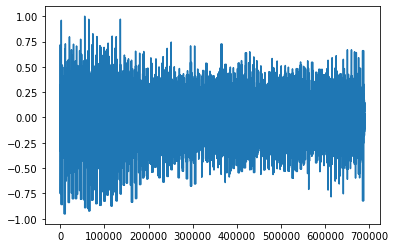

In [3]:
bit_array = bitsFromTiff('jaguar.tiff')
print('Length of bytes', len(bit_array)/8)

payload = fullTrans(bit_array, ofdm)
payloadflat = payload.flatten() / np.max(np.abs(payload.flatten()))
plt.plot((payloadflat.flatten()))
np.max(np.abs(payload.flatten()))
payload.flatten()[0]

In [4]:
data = bit_array
ldpc = LDPC(rate = ofdm.rate, z = ofdm.z)
ldpc_ified = ldpc.encode(data)

symb = bit2symbol(ldpc_ified, ofdm)

cut_symb = cut2Blocks(symb, ofdm)
# syb_padded = addpadding(cut_symb, ofdm)
all_symbs = goodSymbols(cut_symb,ofdm)
print(np.shape(all_symbs))
print(all_symbs[4][2048-ofdm.pilot_locs])
tds = ifft(all_symbs, 2048)
#print(addGuard(tds, ofdm))

(299, 2048)
[1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j
 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j
 1.-1.j]


In [5]:
def CUSTARDtrial(payload,ofdm):
    chirp = double_chirp().flatten()
    exported_even, exported_odd = np.loadtxt('preamble_ofdm_symbols.csv',delimiter=',')
    two_snc = np.concatenate((exported_even, exported_odd)).flatten()
    four_snc = np.concatenate((two_snc, two_snc)).flatten()

    transmission = np.concatenate((chirp,four_snc))
    for i in range(len(payload)//ofdm.sfp):
        transmission = np.concatenate((transmission, payload[i*60:60*i+60].flatten(), two_snc))
    if len(payload)%ofdm.sfp != 0:
        transmission = np.concatenate((transmission, payload[-len(payload)%ofdm.sfp:].flatten(), chirp))
    
    return transmission

In [6]:
for i in range(127//60):
    print(i)
print(127%60)

0
1
7


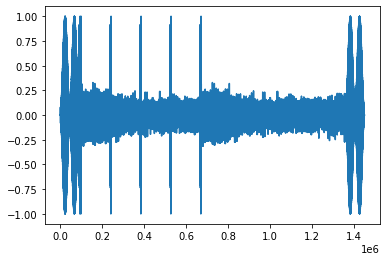

In [7]:
x = CUSTARDtrial(payload, ofdm)
plt.plot(x)